[UCR Time Series Anomaly Detection Benchmark Datasets](https://arxiv.org/pdf/2009.13807v5.pdf)

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from scipy.signal import detrend
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

seed = 0
np.random.seed(seed)

In [2]:
def block_time_series(sequence, block_length):
    X, y, index = [], [], []
    for i in range(len(sequence) - block_length):
        block = sequence[i:i+block_length]
        target = sequence[i+block_length]
        X.append(block)
        y.append(target)
        index.append(np.arange(i, i+block_length))
    return np.array(X), np.array(y), np.array(index)

In [3]:
def compute_empirical_influence_linear_approx(x, y, X, beta, b):
    EIC = (1/len(X)) * np.linalg.inv(X.T @ X) @ (x * (y - x.T @ beta + b))
    return EIC

In [4]:
def compute_loss_grad(x_test, y_test, beta, b):
  loss_grad = x_test * (y_test - x_test.T @ beta + b)
  return loss_grad

def compute_empirical_influences(x, y, x_val, y_val, X, beta, b):
  eic = compute_empirical_influence_linear_approx(x, y, X, beta, b)
  loss_grad = compute_loss_grad(x_val, y_val, beta, b)
  return loss_grad @ eic

In [5]:
def compute_loo_linear_approx(train_idx, test_idx, X_train, y_train, X_test, y_test, beta, b):
  x, y = X_train[train_idx], y_train[train_idx]
  x_val, y_val = X_test[test_idx], y_test[test_idx]

  loo = compute_empirical_influences(x, y, x_val, y_val, X_train, beta, b)
  return loo

Dataset 1

In [230]:
data_dir = "../ucr_time_series_anomaly_datasets/data"
file_name = "037_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG1_5000_17210_17260.txt"
ts = pd.read_csv(Path(data_dir) / file_name, delimiter='\t', header=None).to_numpy()
ts = ts[17000:17800].squeeze()

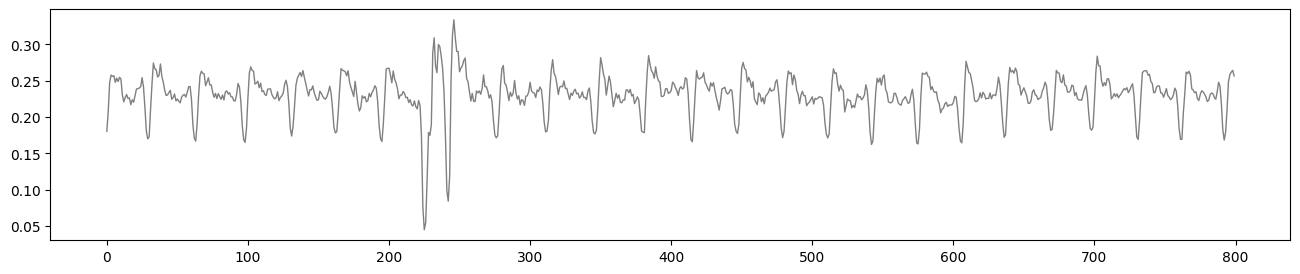

In [231]:
plt.figure(figsize=(16,3))
plt.plot(ts, c="gray", linewidth=1)
plt.show()

In [232]:
seq_len = len(ts)
train_len = int(0.9 * seq_len)
test_len = int(0.1 * seq_len)
ts_train, ts_test = ts[:700], ts[700:]

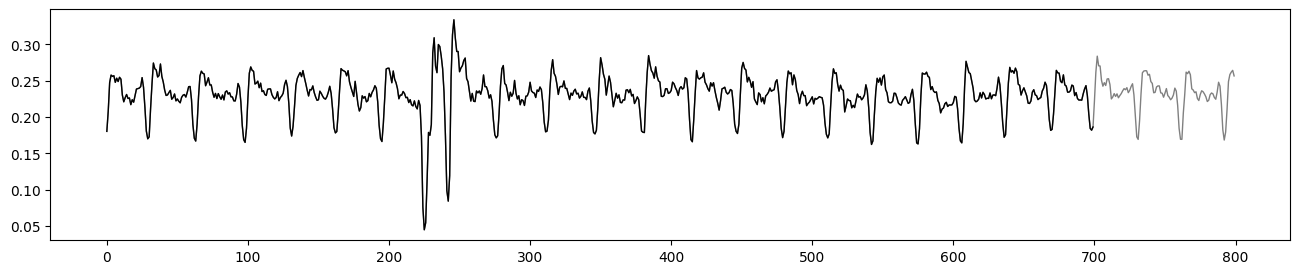

In [233]:
plt.figure(figsize=(16,3))
plt.plot(ts, c="gray", linewidth=1)
plt.plot(ts_train, c="k", linewidth=1)
plt.show()

In [234]:
block_length = 50
X_train, y_train, block_index = block_time_series(ts_train, block_length)
X_test, y_test, _ = block_time_series(ts_test, block_length)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(650, 50) (650,)
(50, 50) (50,)


In [241]:
# faster
train_block_index = []
for i in range(len(X_train)):
    if i < block_length:
        train_index = list(range(i+1))
    elif i > len(ts_train) - block_length:
        delta = len(ts_train) - i
        train_index = list(range(len(X_train) - delta, len(X_train)))   
    else:
        train_index = list(range(i-block_length+1, i+1))
    train_block_index.append(train_index)

In [243]:
lr = LinearRegression().fit(X_train, y_train)
y_hat = lr.predict(X_train)
y_pred = lr.predict(X_test)

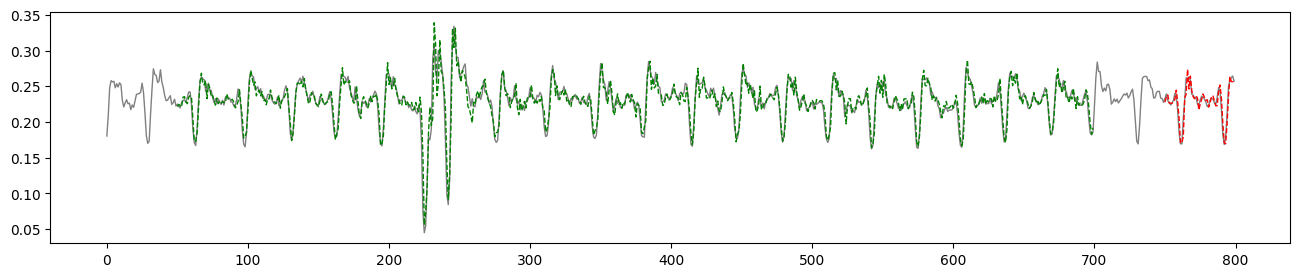

In [244]:
plt.figure(figsize=(16,3))
train_pred = np.ones_like(ts) * np.nan
test_pred = train_pred.copy()
train_pred[block_length:block_length + len(y_hat)] = y_hat
test_pred[-len(y_pred):] = y_pred
plt.plot(ts, c="gray", linewidth=1);
plt.plot(train_pred, c="g", linewidth=1, linestyle="--")
plt.plot(test_pred, c="r", linewidth=1, linestyle="--")
plt.show()

In [245]:
beta = lr.coef_
b = lr.intercept_

train_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  train_loos.append(compute_loo_linear_approx(i, i, X_train, y_train, X_train, y_train, beta, b))
train_loos = np.array(train_loos)

Compute LOO: 100%|██████████████████████████| 650/650 [00:00<00:00, 2874.26it/s]


In [246]:
mean_loos = []
for i in range(len(train_block_index)):
  mean_loos.append((train_loos[train_block_index[i]]).mean())
mean_loos = np.array(mean_loos)

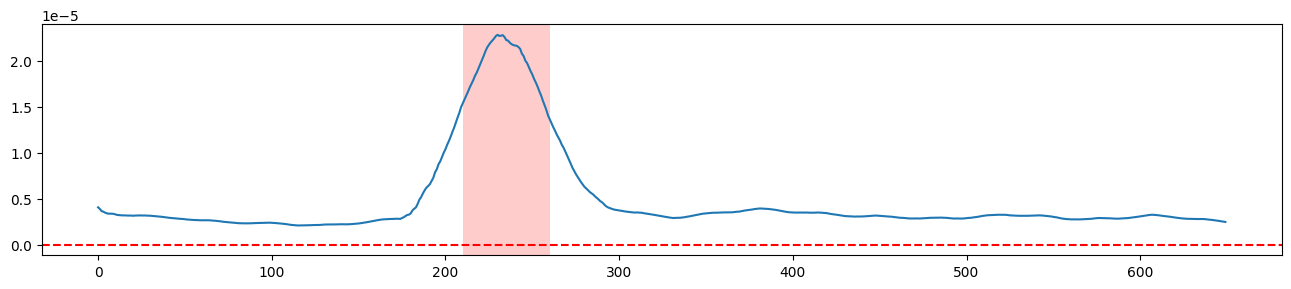

In [248]:
plt.figure(figsize=(16,3))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = mean_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(210, 260, facecolor='red', alpha=.2);

Dataset 2

In [6]:
data_dir = "../ucr_time_series_anomaly_datasets/data/"
file_name = "042_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG6_7000_12190_12420.txt"

ts = pd.read_csv(Path(data_dir) / file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()

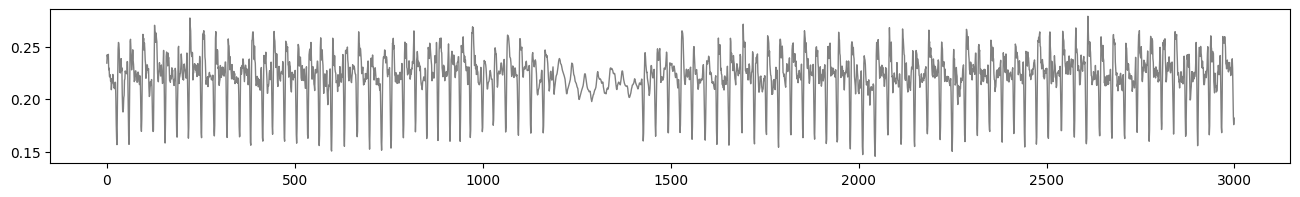

In [7]:
plt.figure(figsize=(16,2))
plt.plot(ts[11000:14000], c="gray", linewidth=1)
plt.show()

In [8]:
seq_len = len(ts)
train_len = int(0.9 * seq_len)
test_len = int(0.1 * seq_len)
ts_train, ts_test = ts[:train_len], ts[train_len:]

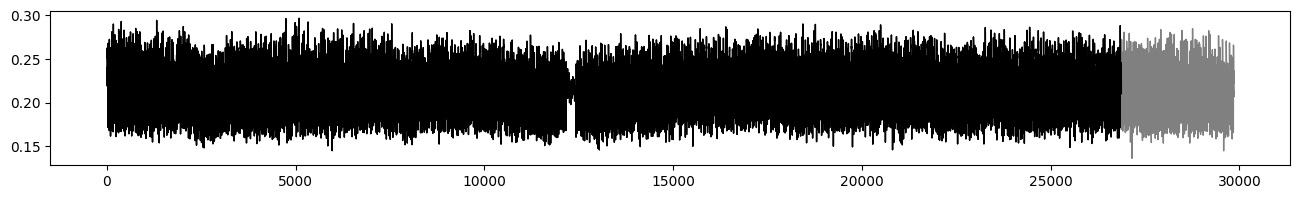

In [9]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.plot(ts_train, c="k", linewidth=1)
plt.show()

In [10]:
block_length = 200
X_train, y_train, block_index = block_time_series(ts_train, block_length)
X_test, y_test, _ = block_time_series(ts_test, block_length)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(26673, 200) (26673,)
(2786, 200) (2786,)


In [11]:
# faster
train_block_index = []
for i in range(len(X_train)):
    if i < block_length:
        train_index = list(range(i+1))
    elif i > len(ts_train) - block_length:
        delta = len(ts_train) - i
        train_index = list(range(len(X_train) - delta, len(X_train)))   
    else:
        train_index = list(range(i-block_length+1, i+1))
    train_block_index.append(train_index)

In [293]:
lr = LinearRegression().fit(X_train, y_train)
y_hat = lr.predict(X_train)
y_pred = lr.predict(X_test)

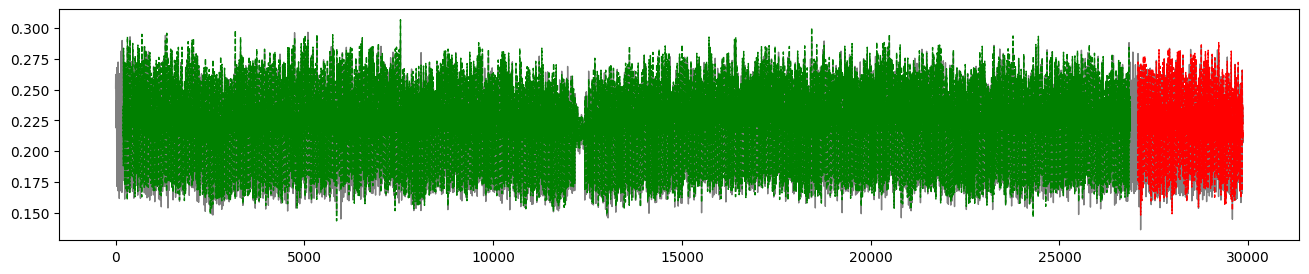

In [294]:
plt.figure(figsize=(16,3))
train_pred = np.ones_like(ts) * np.nan
test_pred = train_pred.copy()
train_pred[block_length:block_length + len(y_hat)] = y_hat
test_pred[-len(y_pred):] = y_pred
plt.plot(ts, c="gray", linewidth=1);
plt.plot(train_pred, c="g", linewidth=1, linestyle="--")
plt.plot(test_pred, c="r", linewidth=1, linestyle="--")
plt.show()

In [295]:
beta = lr.coef_
b = lr.intercept_

train_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  train_loos.append(compute_loo_linear_approx(i, i, X_train, y_train, X_train, y_train, beta, b))
train_loos = np.array(train_loos)

Compute LOO: 100%|████████████████████████| 26673/26673 [14:52<00:00, 29.90it/s]


In [296]:
mean_loos = []
for i in range(len(train_block_index)):
  mean_loos.append((train_loos[train_block_index[i]]).mean())
mean_loos = np.array(mean_loos)

In [38]:
def min_max_scaler(x):
    return (x - x.min()) / (x.max() - x.min())

In [147]:
norm_mean_loos = min_max_scaler(mean_loos)
norm_mean_loos = np.abs(norm_mean_loos - np.nanmean(loos_viz))

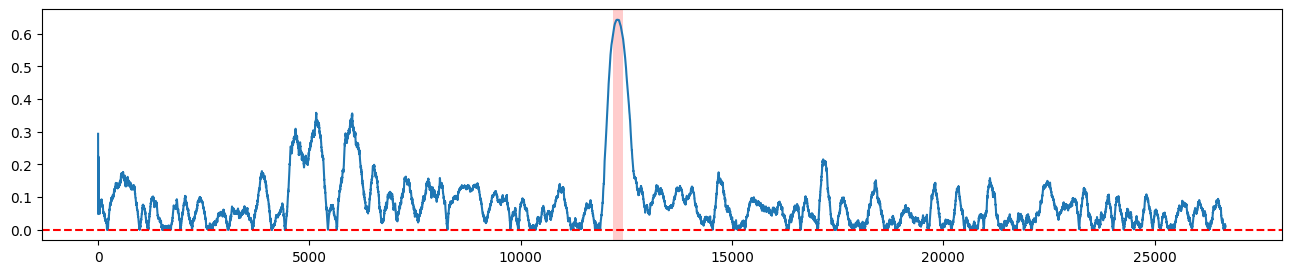

In [165]:
plt.figure(figsize=(16,3))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = norm_mean_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(12190, 12420, facecolor='red', alpha=.2);

In [154]:
truth = np.zeros_like(ts)[:len(mean_loos)]
truth[12190:12420] = 1

In [194]:
outliers = norm_mean_loos > np.quantile(norm_mean_loos, 0.99)

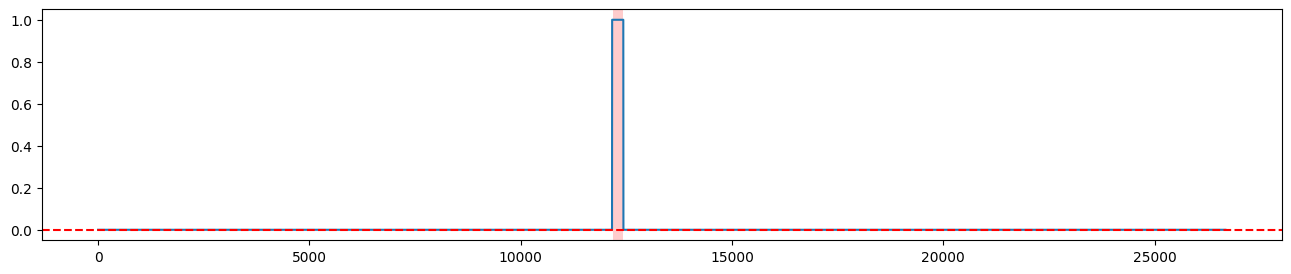

In [195]:
plt.figure(figsize=(16,3))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = outliers
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(12190, 12420, facecolor='red', alpha=.2);

In [196]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(truth[:len(outliers)], outliers))
print(recall_score(truth[:len(outliers)], outliers))
print(f1_score(truth[:len(outliers)], outliers))

0.8614232209737828
1.0
0.9255533199195172


Dataset 3

In [260]:
data_dir = "../ucr_time_series_anomaly_datasets/data"
file_name = "003_UCR_Anomaly_DISTORTED3sddb40_35000_46600_46900.txt"

ts = pd.read_csv(Path(data_dir) / file_name, delimiter='\t', header=None).to_numpy()
ts = ts[46000:47500].squeeze()

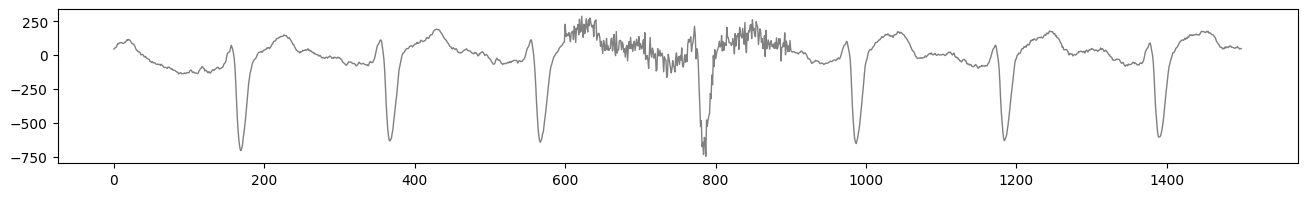

In [261]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.show()

In [262]:
seq_len = len(ts)
train_len = int(0.8 * seq_len)
test_len = int(0.2 * seq_len)
ts_train, ts_test = ts[:train_len], ts[train_len:]

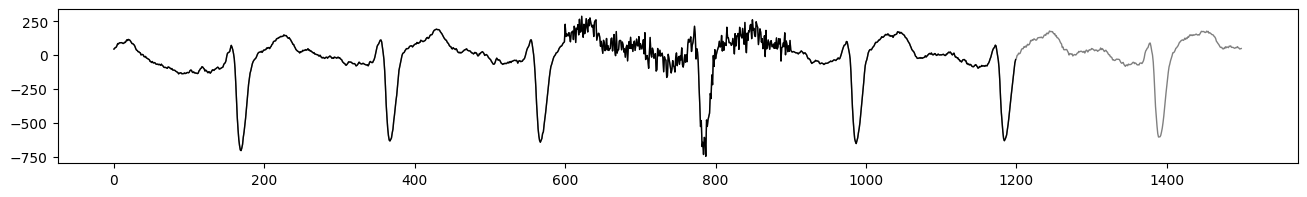

In [263]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.plot(ts_train, c="k", linewidth=1)
plt.show()

In [264]:
block_length = 50
X_train, y_train, block_index = block_time_series(ts_train, block_length)
X_test, y_test, _ = block_time_series(ts_test, block_length)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1150, 50) (1150,)
(250, 50) (250,)


In [265]:
# faster
train_block_index = []
for i in range(len(X_train)):
    if i < block_length:
        train_index = list(range(i+1))
    elif i > len(ts_train) - block_length:
        delta = len(ts_train) - i
        train_index = list(range(len(X_train) - delta, len(X_train)))   
    else:
        train_index = list(range(i-block_length+1, i+1))
    train_block_index.append(train_index)

In [266]:
lr = LinearRegression().fit(X_train, y_train)
y_hat = lr.predict(X_train)
y_pred = lr.predict(X_test)

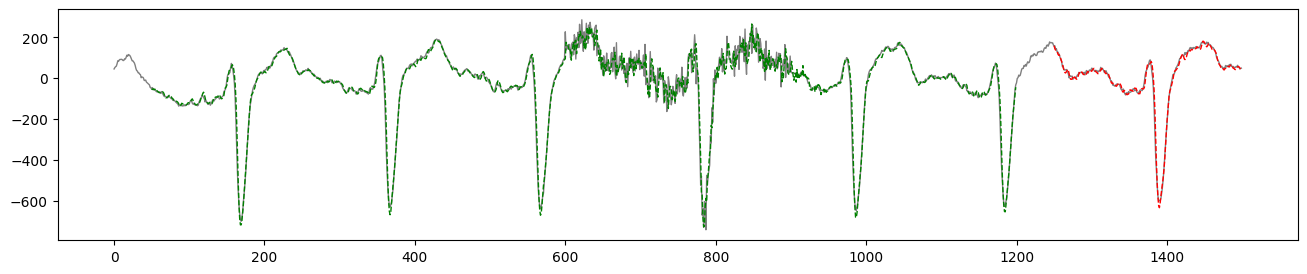

In [267]:
plt.figure(figsize=(16,3))
train_pred = np.ones_like(ts) * np.nan
test_pred = train_pred.copy()
train_pred[block_length:block_length + len(y_hat)] = y_hat
test_pred[-len(y_pred):] = y_pred
plt.plot(ts, c="gray", linewidth=1);
plt.plot(train_pred, c="g", linewidth=1, linestyle="--")
plt.plot(test_pred, c="r", linewidth=1, linestyle="--")
plt.show()

In [268]:
beta = lr.coef_
b = lr.intercept_

train_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  train_loos.append(compute_loo_linear_approx(i, i, X_train, y_train, X_train, y_train, beta, b))
train_loos = np.array(train_loos)

Compute LOO: 100%|████████████████████████| 1150/1150 [00:00<00:00, 2345.93it/s]


In [269]:
mean_loos = []
for i in range(len(train_block_index)):
  mean_loos.append((train_loos[train_block_index[i]]).mean())
mean_loos = np.array(mean_loos)

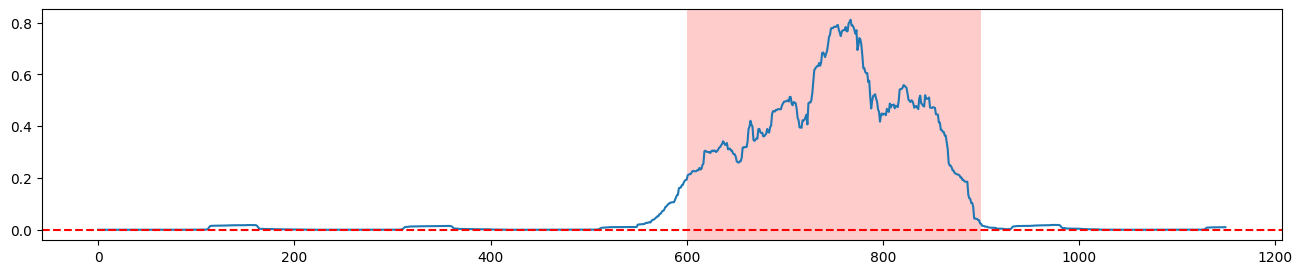

In [270]:
plt.figure(figsize=(16,3))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = mean_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(600, 900, facecolor='red', alpha=.2);

Dataset 4

In [271]:
data_dir = "../ucr_time_series_anomaly_datasets/data"
file_name = "062_UCR_Anomaly_DISTORTEDgaitHunt1_18500_33070_33180.txt"

ts = pd.read_csv(Path(data_dir) / file_name, delimiter='\t', header=None).to_numpy()
ts = ts[33000:34000].squeeze()

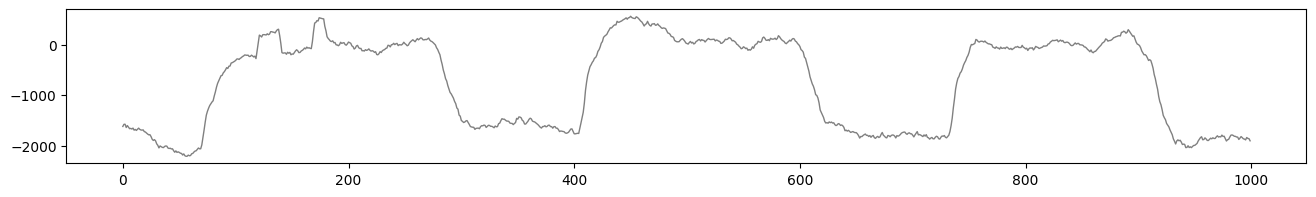

In [272]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.show()

In [273]:
seq_len = len(ts)
train_len = int(0.7 * seq_len)
test_len = int(0.3 * seq_len)
ts_train, ts_test = ts[:train_len], ts[train_len:]

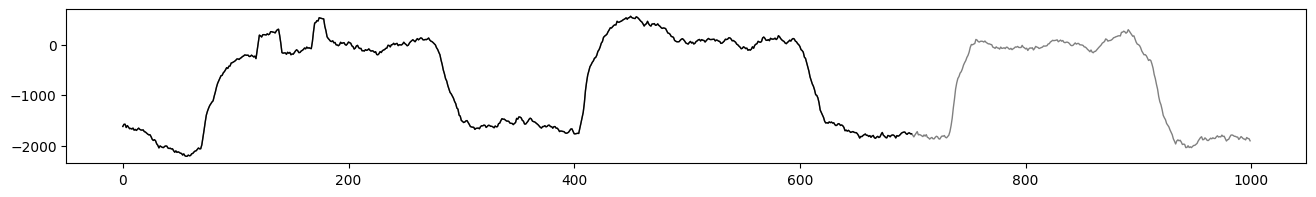

In [274]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.plot(ts_train, c="k", linewidth=1)
plt.show()

In [275]:
block_length = 25
X_train, y_train, block_index = block_time_series(ts_train, block_length)
X_test, y_test, _ = block_time_series(ts_test, block_length)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(675, 25) (675,)
(275, 25) (275,)


In [276]:
# faster
train_block_index = []
for i in range(len(X_train)):
    if i < block_length:
        train_index = list(range(i+1))
    elif i > len(ts_train) - block_length:
        delta = len(ts_train) - i
        train_index = list(range(len(X_train) - delta, len(X_train)))   
    else:
        train_index = list(range(i-block_length+1, i+1))
    train_block_index.append(train_index)

In [277]:
lr = LinearRegression().fit(X_train, y_train)
y_hat = lr.predict(X_train)
y_pred = lr.predict(X_test)

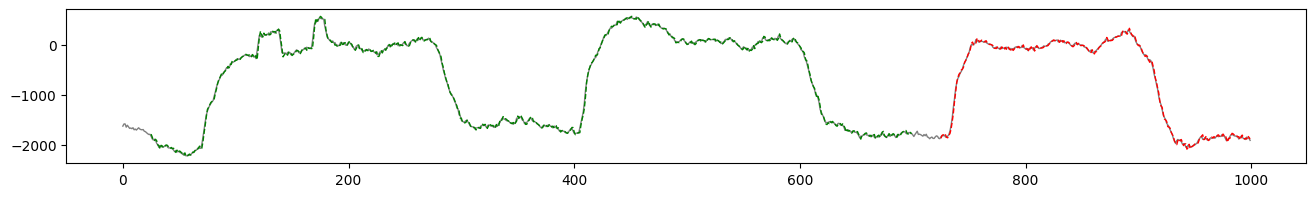

In [278]:
plt.figure(figsize=(16,2))
train_pred = np.ones_like(ts) * np.nan
test_pred = train_pred.copy()
train_pred[block_length:block_length + len(y_hat)] = y_hat
test_pred[-len(y_pred):] = y_pred
plt.plot(ts, c="gray", linewidth=1);
plt.plot(train_pred, c="g", linewidth=1, linestyle="--")
plt.plot(test_pred, c="r", linewidth=1, linestyle="--")
plt.show()

In [279]:
beta = lr.coef_
b = lr.intercept_

train_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  train_loos.append(compute_loo_linear_approx(i, i, X_train, y_train, X_train, y_train, beta, b))
train_loos = np.array(train_loos)

Compute LOO: 100%|██████████████████████████| 675/675 [00:00<00:00, 6205.75it/s]


In [280]:
mean_loos = []
for i in range(len(train_block_index)):
  mean_loos.append((train_loos[train_block_index[i]]).mean())
mean_loos = np.array(mean_loos)

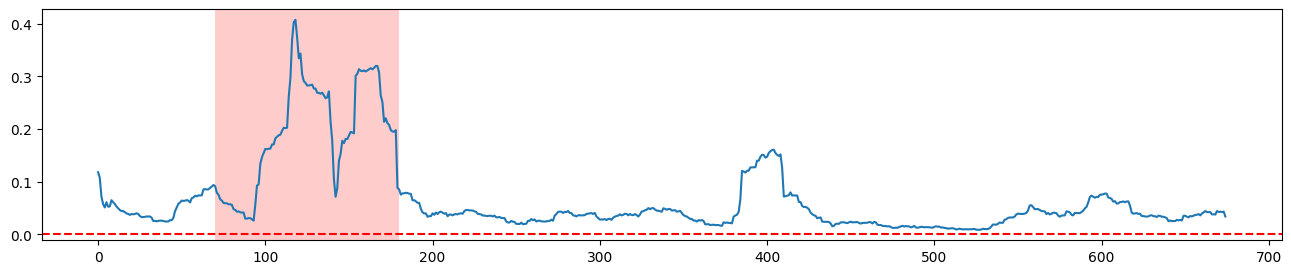

In [281]:
plt.figure(figsize=(16,3))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = mean_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(70, 180, facecolor='red', alpha=.2);